In [175]:
#Imports
import string
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import nltk
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk import FreqDist
from nltk import bigrams

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Reading dataset and cleaning data

In [2]:
fakenews_df = pd.read_csv("fake.csv")

In [3]:
len(fakenews_df)

12999

Dropping columns with lots of nulls

In [4]:
fakenews_df =  fakenews_df.drop(['author','domain_rank','main_img_url'], axis=1) 

Dropping rows without titles and texts

In [5]:
fakenews_df = fakenews_df.dropna(subset=['title','text'])

In [ ]:
len(fakenews_df)

In [6]:
fakenews_df.head()

,uuid,ord_in_thread,published,title,text,language,crawled,site_url,country,thread_title,spam_score,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,0,0,0,0,0,bias


### Preprocessing
Lower case text, remove stop words and punctuation and lemmatize nouns, verbs, adverbs and adjectives based on POS tagging

In [44]:
class NLTKPreprocessor(BaseEstimator, TransformerMixin):

    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def tokenize(self, document):
        # Break the document into sentences
        for sent in sent_tokenize(document):
            # Break the sentence into part of speech tagged tokens
            for token, tag in pos_tag(wordpunct_tokenize(sent)):
                # Apply preprocessing to the token
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
                token = token.strip('_') if self.strip else token
                token = token.strip('*') if self.strip else token
                token = token.strip('»') if self.strip else token
                token = token.strip('…') if self.strip else token
                token = token.strip('“') if self.strip else token
                token = token.strip('’') if self.strip else token

                # If stopword, ignore token and continue
                if token in self.stopwords:
                    continue
                  
                # If digit, ignore token and continue
                if token.isdigit():
                    continue

                # If punctuation, ignore token and continue
                if all(char in self.punct for char in token):
                    continue

                # Lemmatize the token and yield
                lemma = self.lemmatize(token, tag)
                yield lemma

    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

preprocessor = NLTKPreprocessor()

Preprocess title and text columns

In [45]:
fakenews_df['pre_title'] = preprocessor.fit_transform([title for title in fakenews_df.title])

In [46]:
fakenews_df['pre_text'] = preprocessor.fit_transform([text for text in fakenews_df.text])

Combine preprocessed title and text columns

In [63]:
fakenews_df['pre_title_text'] = fakenews_df['pre_title'] + fakenews_df['pre_text']

### Statistical Analysis

#### Types of news articles in the dataset

In [7]:
fakenews_df.type.value_counts()

bs            10919
conspiracy      412
bias            354
hate            246
state           121
junksci         102
satire          100
fake             19
Name: type, dtype: int64

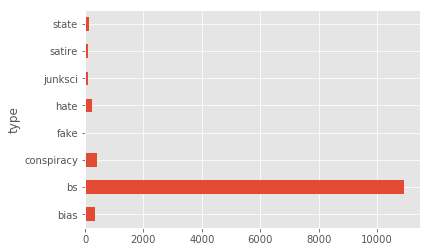

In [142]:
fakenews_df.groupby('type').size().plot(kind='barh')

#### Relationship between type of news articles and likes, comments, shares and spam score

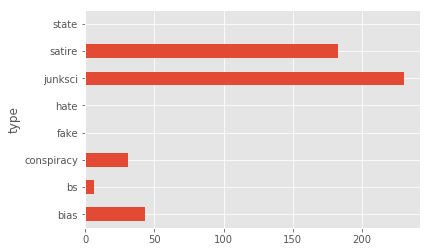

In [136]:
fakenews_df.groupby('type')['likes'].mean().plot(kind='barh')

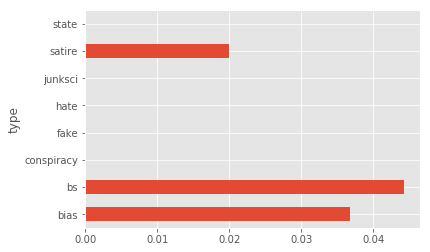

In [138]:
fakenews_df.groupby('type')['comments'].mean().plot(kind='barh')

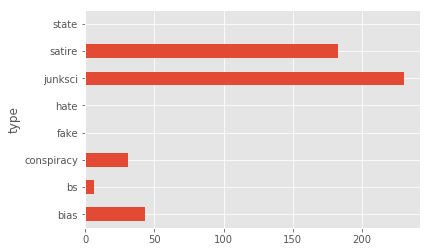

In [139]:
fakenews_df.groupby('type')['shares'].mean().plot(kind='barh')

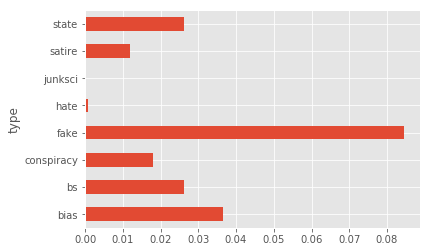

In [143]:
fakenews_df.groupby('type')['spam_score'].mean().plot(kind='barh')

#### Most frequent words in the title + text

In [ ]:
tokenized_words = []
for word in fakenews_df.pre_title_text:
    tokenized_words = tokenized_words + word

In [124]:
def plot_bar_graph(counter, most_common, concatenate_label=False):
    labels = []
    values = []
    if concatenate_label:
        labels = [" ".join(e[0]) for e in counter.most_common(most_common)]
    else:
        labels = [e[0] for e in counter.most_common(most_common)]
    values = [e[1] for e in counter.most_common(most_common)]
    indexes = np.arange(len(labels))
    plt.barh(indexes, values)
    plt.yticks(indexes, labels)
    plt.show()

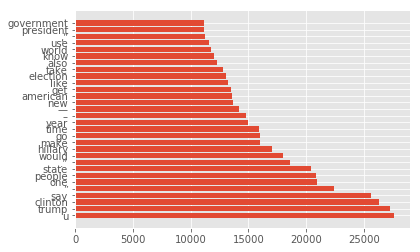

In [126]:
fdist = FreqDist(tokenized_words)
plot_bar_graph(fdist, 30)

#### Most frequest bigrams in title + text

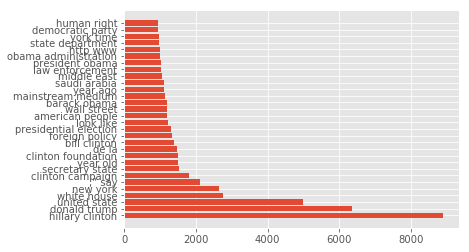

In [127]:
bigram_words = bigrams(tokenized_words)
counter = Counter(bigram_words)
plot_bar_graph(counter, 30, True)

#### Most common websites publishing fake news

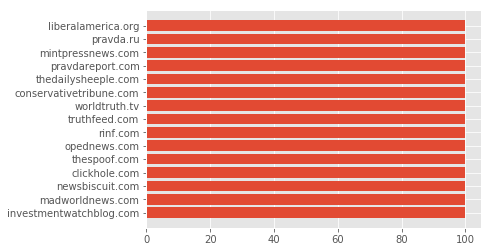

In [128]:
counter = Counter(fakenews_df['site_url'])
plot_bar_graph(counter, 15)

### Wordcloud of most frequent words

In [50]:
combined_titles_list = [" ".join(word) for word in fakenews_df['pre_title']]
combined_titles = ""
for title in combined_titles_list:
    combined_titles = combined_titles + " " + title

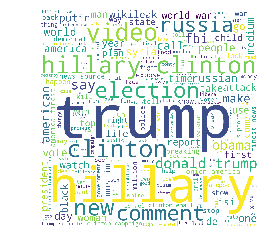

In [57]:
wordcloud = WordCloud(background_color='white', width=1200, height=1200).generate(combined_titles)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [64]:
combined_text_list = [" ".join(word) for word in fakenews_df['pre_text']]
combined_text = ""
for text in combined_text_list:
    combined_text = combined_text + " " + text

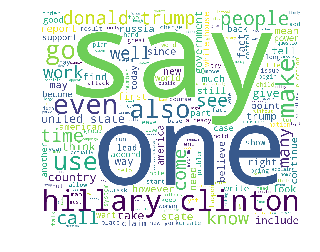

In [72]:
wordcloud = WordCloud(background_color='white', width=1200, height=1000).generate(combined_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
combined_title_text_list = [" ".join(word) for word in fakenews_df['pre_title_text']]
combined_title_text = ""
for title_text in combined_title_text_list:
    combined_title_text = combined_title_text + " " + title_text

In [ ]:
wordcloud = WordCloud(background_color='white', width=1200, height=1000).generate(combined_title_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Feature Extraction and Clustering

Using frequency of words (divided by inter row frequency) in the dataset as a feature.

In [159]:
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(" ".join(word) for word in fakenews_df['pre_title_text'])

Finding the best value of K (number of clusters)

In [165]:
for i in range(2,15):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(vector)
    print(silhouette_score(vector, kmeans.labels_, metric='euclidean'))

0.00547359422077
0.00900269987988
0.00606850072171
0.00794029531369
0.00919237260953
0.0105634865946
0.00993619612289


0.0110596621422

0.0114611044138

0.0128155307748

0.0133168388732 (12)...

Dimensionality reduction using PCA

In [ ]:
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vector.toarray())

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(list(set(fakenews_df.type)))
type_label = le.transform(fakenews_df.type)

Running K-means and plotting the result

In [ ]:
plt.figure('Reference Plot')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=type_label)
#kmeans = KMeans(n_clusters=12, random_state=0)
kmeans.fit_transform(vector)
plt.figure('K-means with 12 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.show()

### Word2Vec